In [10]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5'

In [ ]:
import numpy as np
import jax.numpy as jnp
from temgym_core.components import Lens, Detector
from temgym_core.gaussian import make_gaussian_image, GaussianRay
from temgym_core.source import ParallelBeam
from temgym_core.components import Component
from temgym_core.ray import Ray

import jax
from temgym_core.utils import custom_jacobian_matrix



In [18]:
%matplotlib widget
import matplotlib.pyplot as plt

In [31]:
# Detector setup
pixel_size = 5e-4
shape = (1024, 1024)

In [32]:
ray = Ray(x=0.000, y=0.00, dx=0., dy=0., _one=1.0, pathlength=0.0, z=0.0)
new_ray = Lens(z=0.0, focal_length=5e-3)(ray)

new_ray_abcd = jax.jacobian(Lens(z=0.0, focal_length=5e-3))(ray)
new_ray_abcd = custom_jacobian_matrix(new_ray_abcd)

In [33]:
# Model Creation
f = 5e-3
defocus = 2e-1
z2 = (1 / f) ** -1 + defocus
model = [Lens(z=0.0, focal_length=f), Detector(z=z2, pixel_size=(pixel_size, pixel_size), shape=shape)]

In [37]:
num_rays = 1
wavelength = 1e-4
wo = 0.5e-3
k = 2 * jnp.pi / wavelength

beam = ParallelBeam(0., 0.5e-3)
base_rays = beam.make_rays(num_rays, random=False)
num_rays = jnp.size(base_rays.x)

# Gaussian Beam Input
xs = jnp.array(np.asarray([base_rays.x]))
ys = jnp.array(np.asarray([base_rays.y]))
dxs = jnp.array(np.asarray([base_rays.dx]))
dys = jnp.array(np.asarray([base_rays.dy]))
zs = jnp.array(np.zeros(num_rays))
pathlengths = jnp.array(np.zeros(num_rays))
ones = jnp.array(np.ones(num_rays))
amplitudes = jnp.array(np.ones(num_rays))
radii_of_curv = jnp.array(np.full((num_rays, 2), np.inf))
theta = jnp.array(np.zeros(num_rays))
wavelength = wavelength
wavelengths = jnp.array(np.full((num_rays,), wavelength))
wo = wo
waist_xy = jnp.array(np.full((num_rays, 2), wo))


rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

In [38]:
det_image = make_gaussian_image(rays, model, batch_size=1000)

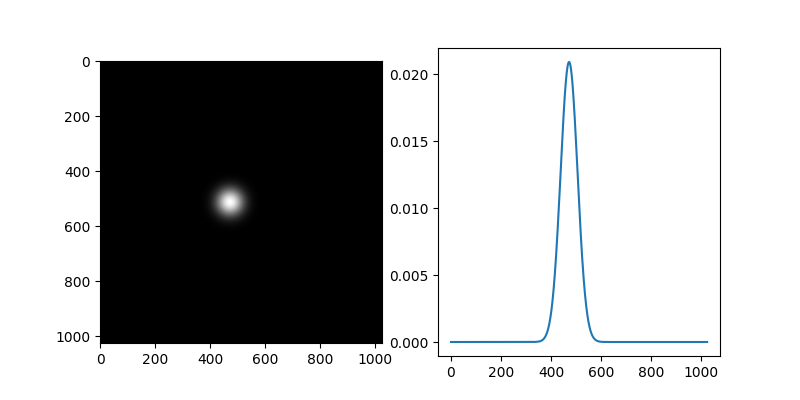

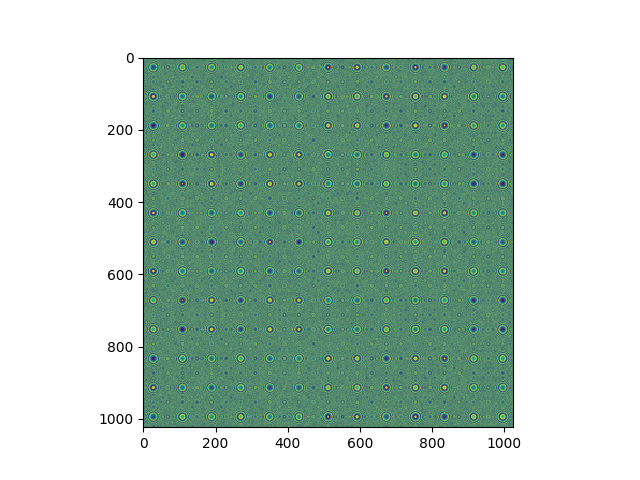

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
img = np.abs(det_image)
ax1.imshow(img, cmap="gray")
ax2.plot(img[img.shape[0]//2, :])

fig, ax = plt.subplots()
ax.imshow(np.angle(det_image), cmap="viridis", vmin=-np.pi, vmax=np.pi)